In [1]:
import pandas as pd
import unidecode
import re

# Read in data

In [3]:
training_data_txt = open('../data/Xtown_ 2019 Hate Crime Write-Ups.txt', encoding='utf-8').read().split('\n')

In [30]:
all_records = []
record = {}
for line in training_data_txt[26:]:
    if line == '':
        continue
    
    line = unidecode.unidecode(line)
    if line.startswith('Week') or re.search('\d+\s{0,1}-\s{0,1}\d+', line):
        if len(record)>0:
            all_records.append(record)
            record = {}
        continue
    
    if 'Assigned to' in line:
        continue
    elif 'Date:' in line:
        record['Datetime'] = ':'.join(line.split(':')[1:]).strip()
    elif 'Suspect\'s Actions:' in line:
        record['Suspect Actions'] = line.replace('Suspect\'s Actions:', '').strip()
    elif 'Crime Type:' in line:
        record['Crime'] = line.replace('Crime Type:', '').strip()
    elif 'Weapon Type:' in line:
        record['Weapon'] = line.replace('Weapon Type:', '').strip()
    elif 'Neighborhood:' in line:
        record['Neighborhood'] = line.replace('Neighborhood:', '').strip()
    elif 'Location:' in line:
        record['Location'] = line.replace('Location:', '').strip()
    elif 'suspect' in line.lower().strip():
        record['Description'] = line.replace('Description:', '').strip()
#     import pdb; pdb.set_trace()

In [31]:
first_records_csv = pd.DataFrame(all_records)

In [32]:
second_records_data_csv = pd.read_csv('../data/Xtown_ Hate Crime Redesign - Sheet1.csv')

In [34]:
all_records_csv = pd.concat([
    first_records_csv,
    second_records_data_csv
], sort=False)

In [35]:
all_records_csv.to_csv('../data/all_records_df.csv', index=False)

In [39]:
all_records_df = pd.read_csv('../data/all_records_df.csv')

In [40]:
raw_data_df = pd.read_csv('../data/raw_data.csv')

# Map Codes to Sentences

In [45]:
raw_data_df['norm_date'] = (raw_data_df['Date Occ']
                            .pipe(lambda s: pd.to_datetime(s, utc=True))
                            .dt.strftime('%Y-%m-%d')
                           )
all_records_df['norm_date'] = (all_records_df['Datetime'].fillna('')
                               .apply(lambda x: x if '2019' in x else (x + ', 2019'))
                               .pipe(lambda s: pd.to_datetime(s, errors='coerce'))
                               .dt.strftime('%Y-%m-%d')
                              )

In [72]:
merged_records_df = (all_records_df
 .merge(raw_data_df, how='left', left_on='norm_date', right_on='norm_date')
 .loc[lambda df: df.apply(lambda x: match_location(x['Neighborhood_x'], x['Neighborhood_y']) > .7, axis=1)]
 .loc[lambda df: df.apply(lambda x: match_location(x['Location_x'], x['Location_y']) > .7, axis=1)]
)

In [56]:
import datetime
import jellyfish
import re

In [66]:
def match_location(loc_1, loc_2):
    ## fix formatting
    if pd.isnull(loc_1):
        loc_1 = ''
    if pd.isnull(loc_2):
        loc_2 = ''
    loc_1 = ' %s ' % loc_1.strip().lower()
    loc_2 = ' %s ' % loc_2.strip().lower()
           
    ## match on numbers 
    numbers_1 = re.findall('\d+', loc_1)
    numbers_2 = re.findall('\d+', loc_2)
    num_match = True
    if len(numbers_1) != len(numbers_2):
        num_match = False
    
    for n_1, n_2 in zip(numbers_1, numbers_2):
        num_match = num_match and (n_1 == n_2)
      
    ## format for matching...
    ## remove numbers 
    numbers_1 = re.sub('\d+', ' ', loc_1)
    numbers_2 = re.sub('\d+', ' ', loc_2)
    
    ## remove other stuff
    to_remove = ['block of', 'th']
    to_replace = {'ave': 'av', 'street': 'st', 
                  'blvd': 'bl', 'west' :'w', 
                  'east': 'e', 'south': 's',
                  'north': 'n', 'highway': 'hy'
                 }
    for r in to_remove:
        loc_1 = loc_1.replace(' %s ' % r, ' ')
        loc_2 = loc_2.replace(' %s ' % r, ' ')
        
    for r_old, r_new in to_replace.items():
        loc_1 = loc_1.replace(' %s ' % r_old, ' %s ' % r_new)
        loc_2 = loc_2.replace(' %s ' % r_new, ' %s ' % r_new)
 
    loc_1 = ' '.join(loc_1.split())
    loc_2 = ' '.join(loc_2.split())
    
    dist = jellyfish.jaro_distance(loc_1, loc_2)
    if num_match:
        return dist
    else:
        return dist > .95


In [217]:
loc_matcher = []
for loc_1 in raw_data_df['Location'].str.lower().str.replace('.', '').unique():
    for loc_2 in data_df['Location'].str.lower().str.replace(', los angeles', '').str.replace('.', '').unique():
        loc_matcher.append({
            'loc_raw': loc_1,
            'loc_spread': loc_2,
            'distance': match_location(loc_1, loc_2)
        })

In [221]:
loc_matcher_df = pd.DataFrame(loc_matcher).loc[lambda df: df['distance'] > .8]

In [44]:
unique_data_df = data_df.loc[unique_idx]

# Look at sentence overlaps to learn templates

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
import difflib
import itertools

In [72]:
diff_comparison = []

for desc_1_idx in range(len(unique_data_df)):
    for desc_2_idx in range(desc_1_idx+1, len(unique_data_df)):
        ## what is the overlap between desc_1 and desc_2
        d1 = unique_data_df['Description'].iloc[desc_1_idx].strip()
        d2 = unique_data_df['Description'].iloc[desc_2_idx].strip()
        
        d1_sents = list(nlp(d1).sents)
        d2_sents = list(nlp(d2).sents)
        
        for sentence_1, sentence_2 in itertools.product(d1_sents, d2_sents):
        
        max_len = max(len(d1), len(d2))

        diff = difflib.ndiff(d1, d2)
        diff_list = list(diff)
        common_diff = list(filter(lambda x: x[0] not in  ['+', '-', '?'], diff_list))
        diff_ratio = len(common_diff) / max_len
        
        diff_comparison.append({
            'd1': d1,
            'd2': d2,
            'diff_list': diff_list,
            'common_diff': common_diff,
            'diff_ratio': diff_ratio
        })

In [74]:
diff_comp_df = pd.DataFrame(diff_comparison)

In [78]:
%matplotlib inline

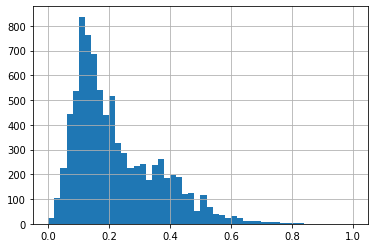

In [80]:
diff_comp_df['diff_ratio'].hist(bins=50)

In [83]:
diff_comp_df.loc[lambda df : df['diff_ratio'] > .4].iloc[0]['common_diff']

['  The',
 '  suspect',
 '  the',
 '  of',
 '  The',
 '  crime',
 '  was',
 '  reported',
 '  as',
 '  a',
 '  hate',
 '  crime',
 '  with']